# Boostrapping

Initialize visual odometry wiht bootstrapping

## Google Colab


In [1]:
# from google.colab import drive

# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/Colab Notebooks'

# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import math
# import scipy.signal
# import scipy.linalg
# import importlib
# import mae6292.tools as mae6292

# from google.colab.patches import cv2_imshow
# from google.colab import files as FILE
# import os

## Jupyter Notebook

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Boostrapping

Bootstrapping is to initialize VO from two-view geometry.

This is to determine the relative pose (up to scale) and the 3D location of features from the correspondence over two views, which is often chosen as the first and and the second video frame. If the baseline is too short, the subsequent frames can be chosen instead.

We use the eight-point algorithm, which is composed of
1. 2D-to-2D correpondence of features
2. Compute Essential matrix $E=\hat T R$
3. Extract the pose $(R,T)$ from $E$
4. Triangulate the 3D location of features.

Recall, in HW#8, we did RANSAC localization using 2D-to-3D correspondence, assuming that the bootstrapping is completed.

### 2D-to-2D Correspondence with KLT

From the zeroth frame, we extact keypoints using Harris detector.

(376, 1241)


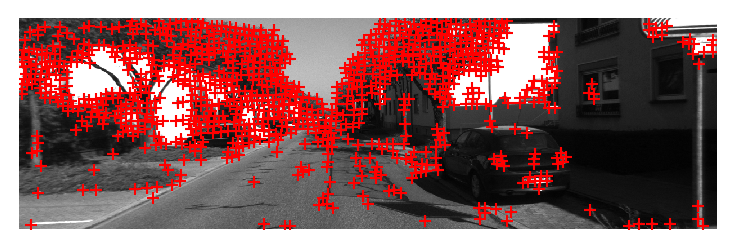

In [2]:
K = np.loadtxt('data/K.txt')
img0 = cv2.imread('data/000000.png', cv2.IMREAD_GRAYSCALE)
print(img0.shape)

W_harris_patch, kappa_harris = 4, 0.08
N_keypoint, W_nms = 1000, 8
harris_scores = mae6292.harris_corner(img0, W_harris_patch, kappa_harris)
keypoints0 = mae6292.select_keypoints(harris_scores, N_keypoint, W_nms)

plt.figure(dpi=150)
plt.imshow(img0,cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.plot(np.array(keypoints0).T[1,:],np.array(keypoints0).T[0,:],'r+')


Next, we load the next frame. Intead of extracting new features and matching them with the previous frame, we use KLT tracker. This results in more matched features and the location of features are given as floating point numbers, which increases the accuracy of the triangulation.

855


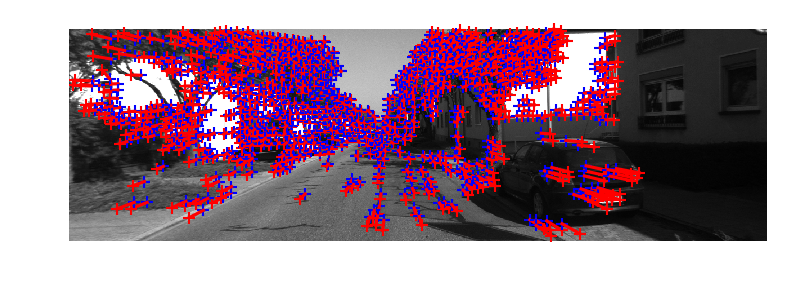

In [3]:
importlib.reload(mae6292)

p0 = np.array(keypoints0, dtype='float32').T
p0 = p0[[1,0],:] 

img1 = cv2.imread('data/000001.png', cv2.IMREAD_GRAYSCALE)
p1, index_track = mae6292.KLT(img0, img1, p0, W=7, tol_bidir = 0.5, display = True)

p0 = p0[:,index_track]
p1 = p1[:,index_track]
print(len(index_track))


### Compute Essential Matrix

Next, we compute the essential matrix. In class, we implemented the eight-point algorithm by
```
E, R, T = mae6292.eightpoint_algorithm(p1, p2, K1, K2)
```
and utilized it in HW#7. 

The KITTI data set may result in a lot of outliers. So, we use the eight-point algorithm with RANSAC by

[`E, bool_inliers = cv2.findEssentialMat(p0.T, p1.T, K, cv2.RANSAC, prob=0.99, threshold=1)`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga0b166d41926a7793ab1c351dbaa9ffd4)

where the threshold for the distance to the epipolar line.

In [4]:
E, bool_inliers = cv2.findEssentialMat(p0.T, p1.T, K, cv2.RANSAC, prob=0.99, threshold=1)

index_inliers = np.where(bool_inliers.flatten() > 0)[0]
p0 = p0[:, index_inliers]
p1 = p1[:, index_inliers]

print('E=',E)
print(len(index_inliers))

E= [[ 2.42711337e-04 -7.06114994e-01 -1.82988859e-02]
 [ 7.06128807e-01  1.46769478e-04  3.32789359e-02]
 [ 1.65815896e-02 -3.26550566e-02 -6.54013660e-05]]
787


### Extract $(R,T)$ from $E$

Now, we extract the pose $(R,T)$ from $E$. Recall the translation $T$ is computed up to an unknown scale, and usually it is normalized such that $\|T\|=1$. Whereas there is no ambiguity in the attitude $R$.

We have our own implementation. 
```
R, T = mae6292.essentialmatrix2RT(E, p1, p2, K1, K2)
```

We use the opencv implementation

[`ret, R1, T1, bool_pose_inliers = cv2.recoverPose(E, p0.T, p1.T, K)`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gadb7d2dfcc184c1d2f496d8639f4371c0)

In the KITTI dataset, we already know that the translation between the first two frames shoudl be about $0.7\mathrm{m}$. While this is not necessary for VO<, we scale $T$ by 0.7.

In [5]:
ret, R1, T1, bool_pose_inliers = cv2.recoverPose(E, p0.T, p1.T, K)
T1 = T1*0.7

index_inliers = np.where( bool_pose_inliers.flatten() > 0 )[0]
p0 = p0[:, index_inliers]
p1 = p1[:, index_inliers]

print('R1=',R1)
print('T1=',T1)
print(len(index_inliers))

R1= [[ 9.99999565e-01  3.21027062e-04  8.75966402e-04]
 [-3.23169630e-04  9.99996954e-01  2.44690379e-03]
 [-8.75178212e-04 -2.44718581e-03  9.99996623e-01]]
T1= [[ 0.03233222]
 [ 0.01640449]
 [-0.69906046]]
578


### Triangulation

Now we have 2D-to-2D correspondence of features and the relative pose. Using these, we can triangulate the 3D location of the features with triangulation. 
```
p_W = mae6292.triangulation(p0_h, p1_h, M0, M1)
```
The resulting 3D location $p_W$ has the same scale as $T$.


Further, we have the following functions for homogenization and dehomogenization. 
```
def hom(p):
    # input (2 or 3) by n np.array
    # output (3 or 4) by n np.array for homogeneous coordinates
    assert(p.shape[0]==2 or p.shape[0]==3)
    return np.concatenate((p, np.ones((1,p.shape[1])) ), axis=0) 

def deh(p_h):
    # output (3 or 4) by n np.array for homogeneous coordinates
    # input (2 or 3) by n np.array for de-homonized coordinates
    n = p_h.shape[0] - 1
    assert(n==2 or n==3)  
    return p_h[0:n,:]/p_h[n,:]
```    

In [6]:
p0_h = mae6292.hom(p0)
p1_h = mae6292.hom(p1)

M0 = K @ np.concatenate( (np.identity(3), np.zeros((3,1))), axis=1 )
M1 = K @ np.concatenate( (R1, T1), axis=1 )

p_W = mae6292.triangulation(p0_h, p1_h, M0, M1)

index_neg_depth = np.where( p_W[2,:] < 0 )[0]
print(index_neg_depth)



[ 51  85 195 233 253 300 310 339 352 456 504 524 525 532 542 550 554]


The resulting reprojection error divided by the number of landmarks is computed by

In [7]:
err0 = np.sqrt(((mae6292.deh( M0 @ mae6292.hom(p_W)) - p0)**2).sum())/p_W.shape[1]
err1 = np.sqrt(((mae6292.deh( M1 @ mae6292.hom(p_W)) - p1)**2).sum())/p_W.shape[1]
print(err0)
print(err1)


0.19146545624870137
0.3098764795684386


### Visualization

In [17]:
#open a new window for plot
%matplotlib tk 

fig = plt.figure(dpi=150,figsize=(6,10))

fig.add_subplot(2, 1, 1)
plt.imshow(img1,cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.plot(p0[0,:], p0[1,:], 'b+') 
plt.plot(p1[0,:], p1[1,:], 'r+') 

plt.plot(p0[0,index_neg_depth], p0[1,index_neg_depth], 'y+') 
plt.plot(p1[0,index_neg_depth], p1[1,index_neg_depth], 'g+') 


ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.plot(p_W[0,:],p_W[1,:],p_W[2,:],'b.',markersize=1)
ax.set_xlim(-20,20)
ax.set_ylim(-10,5)
ax.set_zlim(0,40)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0., azim=-90)
mae6292.draw_frame(ax, np.identity(3), np.zeros((3,1)),axis_length=0.5)
mae6292.draw_frame(ax, R1, T1, axis_length=0.5)
plt.tight_layout()

### Robust Triangulation

As visulaized above, the triangulated points may have negative depths. To avoid this, we can measure the goodness of each triangulation by the uniqueness of the null space for the matrix requried for triangulation, or by the reprojection error. 

The robust triangulation with these error checking has been implemented by
```
p_W, index_inliers, mu_ratio, err = mae6292.triangulation_robust(p0_h, p1_h, M0, M1, tol_mu=1e-3, tol_rep=0.5)
```


In [13]:
p_W, index_inliers, mu_ratio, err = mae6292.triangulation_robust(p0_h, p1_h, M0, M1, tol_mu=1e-3, tol_rep=0.5)

In [18]:
#open a new window for plot
%matplotlib tk 

fig = plt.figure(dpi=150,figsize=(6,10))

fig.add_subplot(2, 1, 1)
plt.imshow(img1,cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.plot(p0[0,index_inliers], p0[1,index_inliers], 'b+') 
plt.plot(p1[0,index_inliers], p1[1,index_inliers], 'r+') 

ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.plot(p_W[0,index_inliers],p_W[1,index_inliers],p_W[2,index_inliers],'b.',markersize=1)
ax.set_xlim(-20,20)
ax.set_ylim(-10,5)
ax.set_zlim(0,40)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0., azim=-90)
mae6292.draw_frame(ax, np.identity(3), np.zeros((3,1)),axis_length=0.5)
mae6292.draw_frame(ax, R1, T1, axis_length=0.5)
plt.tight_layout()